# Import Necessary libraries 

In [271]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import OneHotEncoder 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score , f1_score
from gensim import corpora, models
import gensim
from gensim.models import LdaModel
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

# Import Data as CSV

In [272]:
data=pd.read_csv('review.csv')

In [273]:
#drop umwanted column
data.drop(columns=['Unnamed: 0'],inplace=True)

In [274]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19830 entries, 0 to 19829
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Restaurant  19830 non-null  object
 1   Review      19830 non-null  object
 2   Rating      19830 non-null  object
 3   Date        19830 non-null  object
dtypes: object(4)
memory usage: 619.8+ KB


# Data Pre-processing

### Rating : remove alphabet characters from rating 

In [275]:
data['Rating'] = data['Rating'].apply(lambda x : re.sub('[a-z]' , '' , x))

In [276]:
#Convert rating to integer
data['Rating']=data['Rating'].astype(int)

### Date : remove unwanted strings and escape sequences from Date

In [277]:
data['Date'] = data['Date'].apply(lambda x : re.sub('[\r\n]*Updated review' , '' , x))

#### change format to datetime object

In [278]:
data['Date'] = pd.to_datetime(data['Date'], format='%b %d, %Y')

# Review

Function to capture food items

In [279]:
def find_item(x):
    x = x.lower()
    items = ['oyster', 'bacon', 'bbq', 'shrimp', 'catfish', 'salad', 'chicken', 'sandwich', 'rice', 'pork', 'lamb', 'crab', 'beef', 'fish', 'toast', 'salmon', 'eggs','burger']
    for i in items:
        if i in x:
            return i
    

In [280]:
data['Item']=data['Review'].apply(find_item)

In [281]:
data_fil= data[data['Item'].notna()]

In [282]:
data_fil.reset_index(drop=True)

,Restaurant,Review,Rating,Date,Item
0,Brenda's French Soul Food,I can't stop thinking about this fried chicken...,5,2023-10-07,chicken
1,Brenda's French Soul Food,Brenda's French Soul Food has been on my list ...,4,2023-10-07,chicken
2,Brenda's French Soul Food,We got there around 11:30am on a Sunday and wa...,5,2023-09-29,oyster
3,Brenda's French Soul Food,My recent visit to Brenda's Soul Food had its ...,3,2023-09-25,oyster
4,Brenda's French Soul Food,Brenda's is KILLING the game when it comes to ...,5,2023-09-02,shrimp
...,...,...,...,...,...
12331,Mama's On Washington Square,"What can I say, the food is delicious and it i...",5,2018-02-23,shrimp
12332,Mama's On Washington Square,I swear brunch places in San Francisco are lik...,4,2015-10-08,toast
12333,Mama's On Washington Square,Long line but TOTALLY worth the wait. I had th...,5,2019-11-22,bacon
12334,Mama's On Washington Square,"Unique menu, at least for out of towners. Mont...",4,2017-06-05,salmon


In [283]:
#data_fil['Year'] = data_fil['Date'].dt.year

# Filtering Data
The data having food items present in review is only taken which helps to get proper insight on relation of food items with ratings.

In [284]:
data_fil.head(5)

,Restaurant,Review,Rating,Date,Item
1,Brenda's French Soul Food,I can't stop thinking about this fried chicken...,5,2023-10-07,chicken
2,Brenda's French Soul Food,Brenda's French Soul Food has been on my list ...,4,2023-10-07,chicken
4,Brenda's French Soul Food,We got there around 11:30am on a Sunday and wa...,5,2023-09-29,oyster
5,Brenda's French Soul Food,My recent visit to Brenda's Soul Food had its ...,3,2023-09-25,oyster
6,Brenda's French Soul Food,Brenda's is KILLING the game when it comes to ...,5,2023-09-02,shrimp


### The popularity of the Restaurant is plotted over time based on the review

In [285]:
#Group data by restaurant and their review
grouped = data_fil.groupby(['Restaurant', data_fil['Date'].dt.year])
average_ratings = grouped['Rating'].mean()

In [286]:
average_ratings = average_ratings.reset_index()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


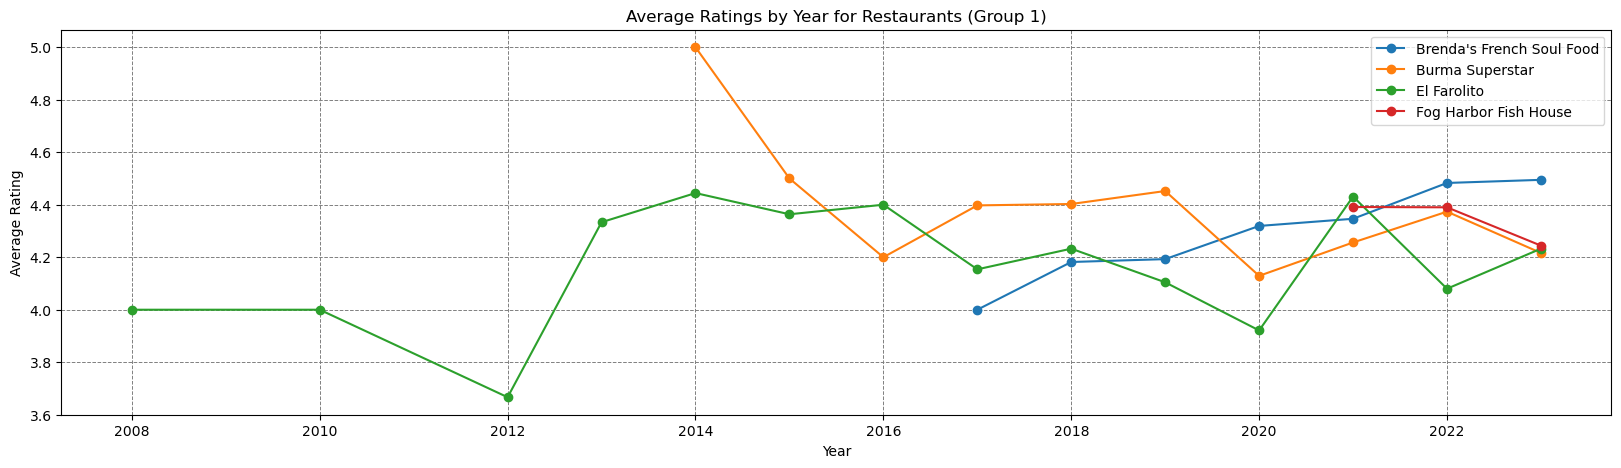

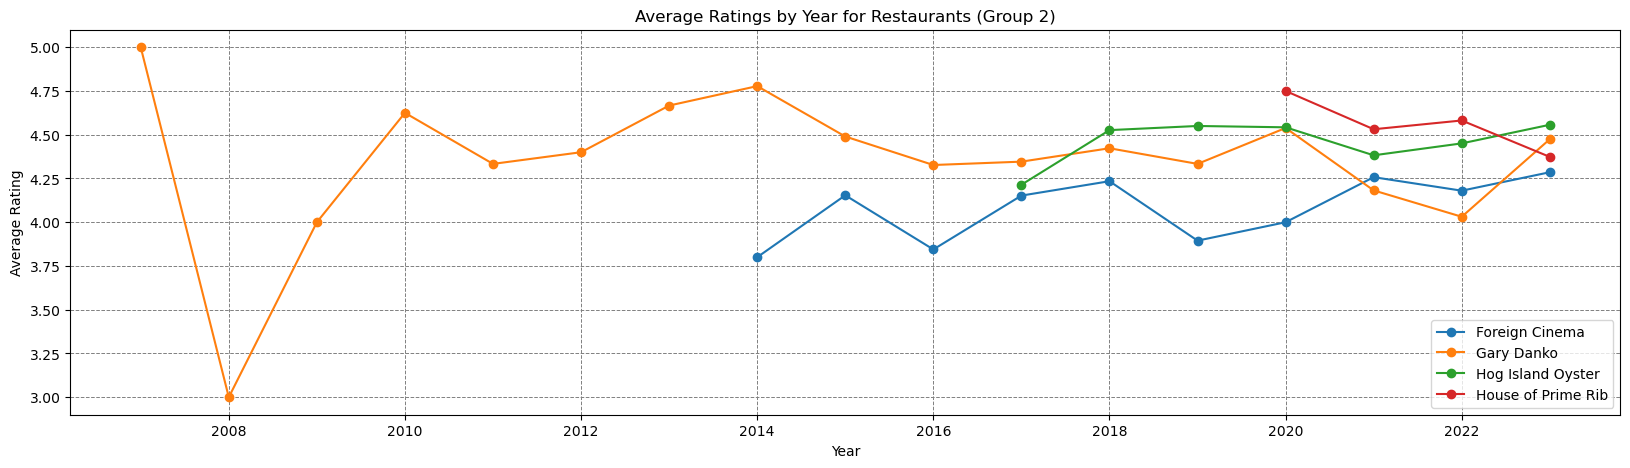

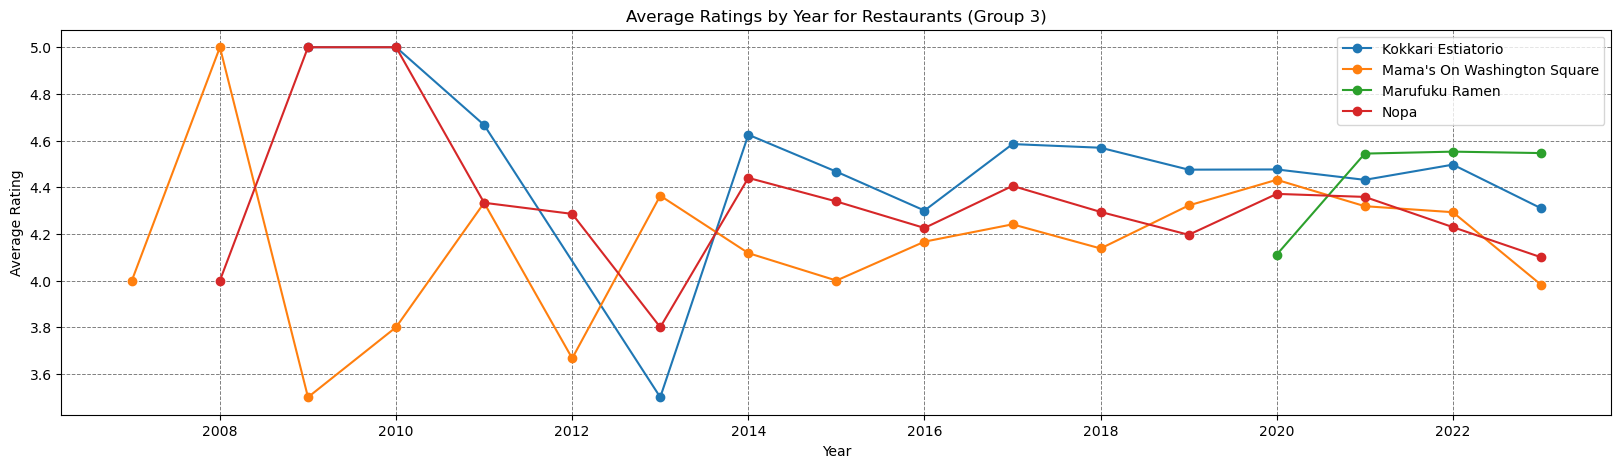

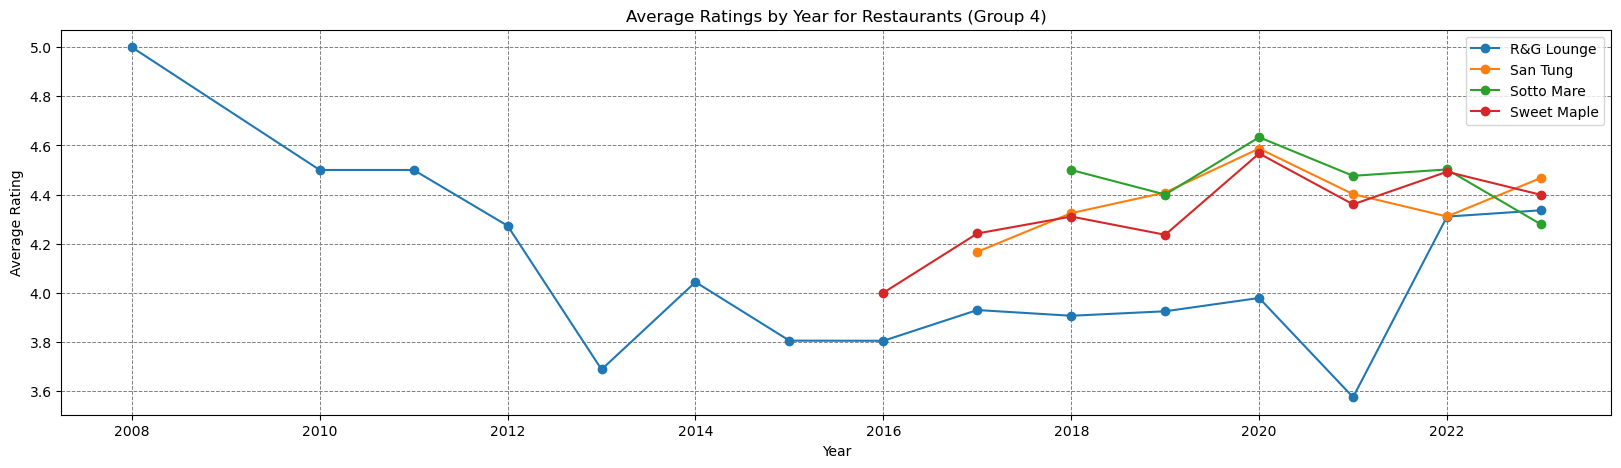

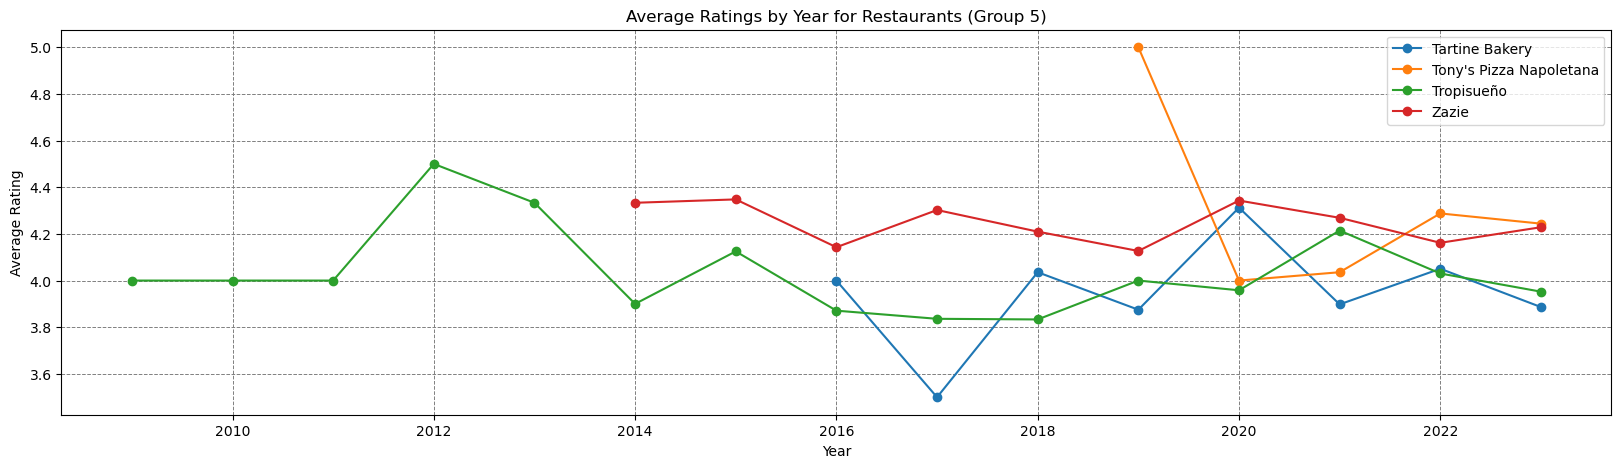

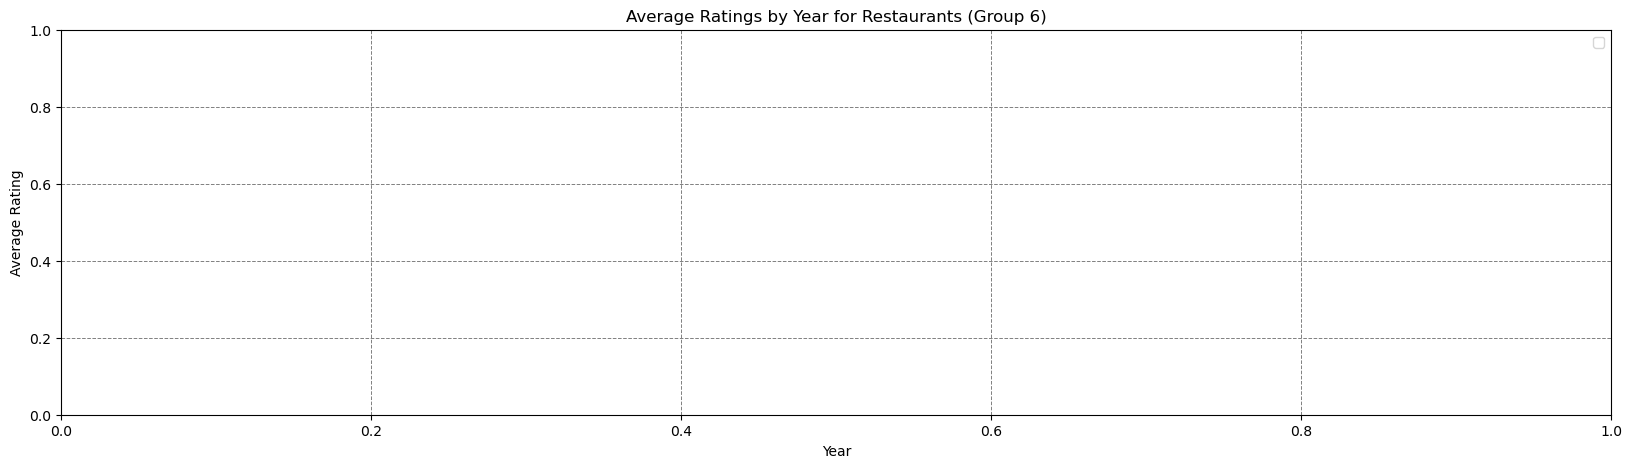

In [287]:
# Plot the rating of restaurant over time
unique_restaurants = average_ratings['Restaurant'].unique()

restaurants_per_group = 4
num_groups = len(unique_restaurants) // restaurants_per_group

for group_num in range(num_groups + 1):
    start_index = group_num * restaurants_per_group
    end_index = start_index + restaurants_per_group

    plt.figure(figsize=(20, 5))
    for i in range(start_index, end_index):
        if i >= len(unique_restaurants):
            break
        restaurant = unique_restaurants[i]
        group_data = average_ratings[average_ratings['Restaurant'] == restaurant]
        plt.plot(group_data['Date'], group_data['Rating'], marker='o', label=restaurant)

    plt.title(f'Average Ratings by Year for Restaurants (Group {group_num + 1})')
    plt.xlabel('Year')
    plt.ylabel('Average Rating')
    plt.legend(loc='best')
    plt.grid(True, color='gray', linestyle='--', linewidth=0.7)
    plt.savefig("Restaurant_rating_series.png")

In [288]:
# save Figure
unique_restaurants = average_ratings['Restaurant'].unique()

restaurants_per_group = 4
num_groups = len(unique_restaurants) // restaurants_per_group

for group_num in range(num_groups + 1):
    start_index = group_num * restaurants_per_group
    end_index = start_index + restaurants_per_group

    plt.figure(figsize=(20, 5))
    for i in range(start_index, end_index):
        if i >= len(unique_restaurants):
            break
        restaurant = unique_restaurants[i]
        group_data = average_ratings[average_ratings['Restaurant'] == restaurant]
        plt.plot(group_data['Date'], group_data['Rating'], marker='o', label=restaurant)

    plt.title(f'Average Ratings by Year for Restaurants (Group {group_num + 1})')
    plt.xlabel('Year')
    plt.ylabel('Average Rating')
    plt.legend(loc='best')
    plt.grid(True, color='gray', linestyle='--', linewidth=0.7)
    
    # Create a unique filename for each plot
    file_name = f"{group_num + 1}.png"
    plt.savefig(file_name)  # Save each plot with its unique filename
    plt.close()  # Close the current figure to start fresh for the next group

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


### Observe the distribution, mean and median of rating  

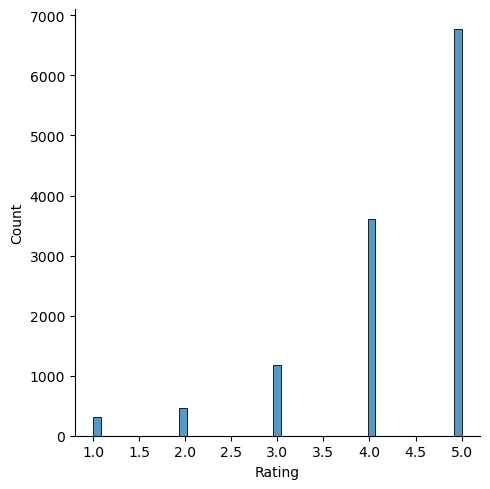

In [289]:
sns.displot(data_fil['Rating'])

In [290]:
data_fil['Rating'].mean()

4.302934500648508

In [291]:
data_fil['Rating'].median()

5.0

## Downsampling the highest rated reviews
The highest rated reviews is dominates other reviews and the mean is highly centred to positive reviews therfore downsampling is neeeded which helps to remove bias towards positive side

In [292]:
high_rating_data = data_fil[(data['Rating'] == 5)]
mid_rating_data  = data_fil[(data['Rating'] == 4)]
downsampled_data_1 = high_rating_data.sample(n=2700, random_state=1)
downsampled_data_2 = mid_rating_data.sample(n=2500, random_state=1)



In [293]:
lowrating_data = data_fil[(data['Rating'] != 4) & (data['Rating'] != 5)]

In [294]:
sampled_data = pd.concat([lowrating_data, downsampled_data_1 ,downsampled_data_2 ], ignore_index=True)

### Downsampled data 

In [295]:
sampled_data.head(5)

,Restaurant,Review,Rating,Date,Item
0,Brenda's French Soul Food,My recent visit to Brenda's Soul Food had its ...,3,2023-09-25,oyster
1,Brenda's French Soul Food,I really wanted to like this place. I found it...,3,2023-07-26,oyster
2,Brenda's French Soul Food,The service was impeccable as ever but the foo...,3,2023-02-24,shrimp
3,Brenda's French Soul Food,Not the experience with food i was hoping for....,3,2023-02-19,chicken
4,Brenda's French Soul Food,UNACCEPTABLE!\r\n\r\nThis was our first stop r...,1,2023-06-22,oyster


### Distribution and mean of downsampled data


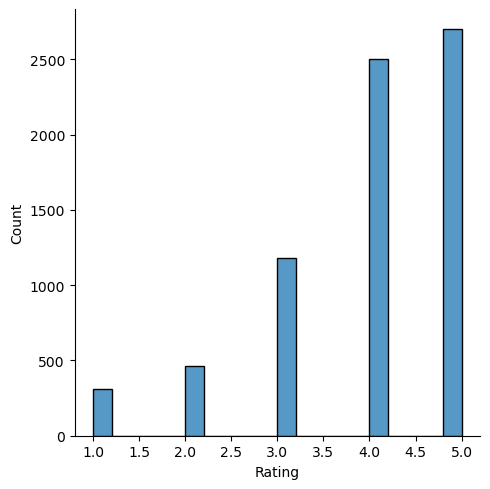

In [296]:
sns.displot(sampled_data['Rating'])


In [297]:
sampled_data['Rating'].mean()

3.9537127674451127

In [298]:
sampled_data['Rating'].median()

4.0

## Preprocessing reviews
In this section, the text reviews are changed to lower case and unwanted characters is removed and also all contractions present in text is changed to expanded form

In [299]:
#Change all data to lowercase
sampled_data['Review'] = sampled_data['Review'].str.lower()

Remove unwanted escape sequences and characters

In [300]:
def remove_unwanted(x):
    pattern = '[\r|\n|\*|\d+]'
    return re.sub(pattern , ' ' , x)

In [301]:
sampled_data['Review']=sampled_data['Review'].apply(remove_unwanted)

### Remove contractions
In this section the contraction is removed with the help of contraction dictionary

In [302]:
contractions_dict = {
    "i'm": "i am",
    "he's" : "he is",
    "i've": "i have",
    "i'll": "i will",
    "i'd" : "i would",
    "you're": "you are",
    "you've": "you have",
    "you'll": "you will",
    "he's": "he is",
    "he'll": "he will",
    "she's": "she is",
    "she'll": "she will",
    "it's": "it is",
    "we're": "we are",
    "we've": "we have",
    "we'll": "we will",
    "they're": "they are",
    "they've": "they have",
    "they'll": "they will",
    "can’t": "cannot",
    "can't" :  "cannot",
    "won't": "will not",
    "isn't": "is not",
    "wouldn't": "would not",
    "what's" : "what is",
    "it'll" : "it will",
    "there's" : "there is",
    "didn't" : "did not" , 
    "doesn't" : "does not",
    "don't" : "do not",
    "it'd" : "it would",
    "they'd" : "they would",
    "it's" : "it is",
    "that's" : "that is",
    "wasn't" : "was not"
}

In [303]:
#Function to remove contractions
def remove_contractions(x):
    split = x.split()
    val = ''
    for word in split:
        if word in contractions_dict:
            word = contractions_dict[word]
        val += word + ' '
    return val.strip()
            

In [304]:
sampled_data['Review']=sampled_data['Review'].apply(remove_contractions)

### Remove Punctuations
Punctuation induces noises in data , by removing it the data becomes more cleaner

In [305]:
#punctuation 

In [306]:
exclude = string.punctuation
def remove_punc(text):
    return text.translate(str.maketrans(' ' , ' ' , exclude))

In [307]:
sampled_data['Review']=sampled_data['Review'].apply(remove_punc)

In [308]:
#tokenize

### Tokenization

In [309]:
tokenized_reviews = []
nltk.download('punkt')
text_data  = sampled_data['Review']
# Tokenize each review 
for review in text_data:
    tokens = word_tokenize(review)
    tokens = [token.lower() for token in tokens if token.isalnum() and token.lower()]
    tokenized_reviews.append(tokens)

[nltk_data] Downloading package punkt to C:\Users\HOME
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Create separate dataframe for tokenized

In [310]:
tokenized_df = pd.DataFrame({'Tokenized_Review': tokenized_reviews})

#### Add tokenized review to data

In [311]:
sampled_data = pd.concat([sampled_data, tokenized_df], axis=1)

In [312]:
sampled_data.head(5)

,Restaurant,Review,Rating,Date,Item,Tokenized_Review
0,Brenda's French Soul Food,my recent visit to brendas soul food had its u...,3,2023-09-25,oyster,"[my, recent, visit, to, brendas, soul, food, h..."
1,Brenda's French Soul Food,i really wanted to like this place i found it ...,3,2023-07-26,oyster,"[i, really, wanted, to, like, this, place, i, ..."
2,Brenda's French Soul Food,the service was impeccable as ever but the foo...,3,2023-02-24,shrimp,"[the, service, was, impeccable, as, ever, but,..."
3,Brenda's French Soul Food,not the experience with food i was hoping for ...,3,2023-02-19,chicken,"[not, the, experience, with, food, i, was, hop..."
4,Brenda's French Soul Food,unacceptable this was our first stop right off...,1,2023-06-22,oyster,"[unacceptable, this, was, our, first, stop, ri..."


### Removing stop words
The data is further enhanced by removing stop words for this , NLTK library is used

In [313]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
new_stopwords = ["would","shall","could","might"]
stop_words.extend(new_stopwords)
stop_words.remove("not")
stop_words=set(stop_words)

[nltk_data] Downloading package stopwords to C:\Users\HOME
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [314]:
def remove_stopwords(tokens):
    return [token for token in tokens if token not in stop_words]


In [315]:
sampled_data['Clean_Review']=sampled_data['Tokenized_Review'].apply(remove_stopwords)

In [316]:
sampled_data.head(5)

,Restaurant,Review,Rating,Date,Item,Tokenized_Review,Clean_Review
0,Brenda's French Soul Food,my recent visit to brendas soul food had its u...,3,2023-09-25,oyster,"[my, recent, visit, to, brendas, soul, food, h...","[recent, visit, brendas, soul, food, ups, down..."
1,Brenda's French Soul Food,i really wanted to like this place i found it ...,3,2023-07-26,oyster,"[i, really, wanted, to, like, this, place, i, ...","[really, wanted, like, place, found, pbs, show..."
2,Brenda's French Soul Food,the service was impeccable as ever but the foo...,3,2023-02-24,shrimp,"[the, service, was, impeccable, as, ever, but,...","[service, impeccable, ever, food, not, amazing..."
3,Brenda's French Soul Food,not the experience with food i was hoping for ...,3,2023-02-19,chicken,"[not, the, experience, with, food, i, was, hop...","[not, experience, food, hoping, fried, chicken..."
4,Brenda's French Soul Food,unacceptable this was our first stop right off...,1,2023-06-22,oyster,"[unacceptable, this, was, our, first, stop, ri...","[unacceptable, first, stop, right, plane, exci..."


## Lemmatizer
In this section after removing stop fords finally lemmatization is done

In [317]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to C:\Users\HOME
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [318]:
def lemmatize(tokens):
    lemmatized_tokens = [lemmatizer.lemmatize(token, wordnet.VERB) for token in tokens]
    return lemmatized_tokens

In [319]:
sampled_data['Lemmatized_Review'] = sampled_data['Clean_Review'].apply(lemmatize)

In [320]:
sampled_data.head(2)

,Restaurant,Review,Rating,Date,Item,Tokenized_Review,Clean_Review,Lemmatized_Review
0,Brenda's French Soul Food,my recent visit to brendas soul food had its u...,3,2023-09-25,oyster,"[my, recent, visit, to, brendas, soul, food, h...","[recent, visit, brendas, soul, food, ups, down...","[recent, visit, brendas, soul, food, up, down,..."
1,Brenda's French Soul Food,i really wanted to like this place i found it ...,3,2023-07-26,oyster,"[i, really, wanted, to, like, this, place, i, ...","[really, wanted, like, place, found, pbs, show...","[really, want, like, place, find, pbs, show, c..."


# Data Visualisation

### Distribution of ratings 

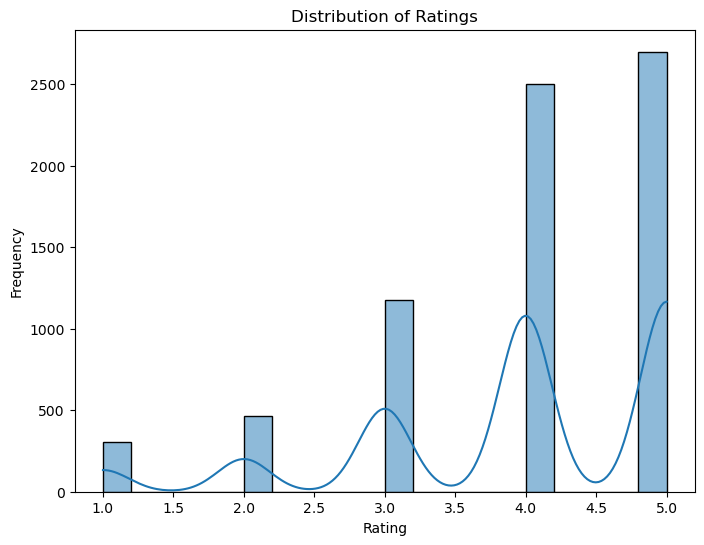

In [321]:
plt.figure(figsize=(8, 6))
sns.histplot(data=sampled_data, x='Rating', bins=20, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

### Plot between no of reviews per Restaurant

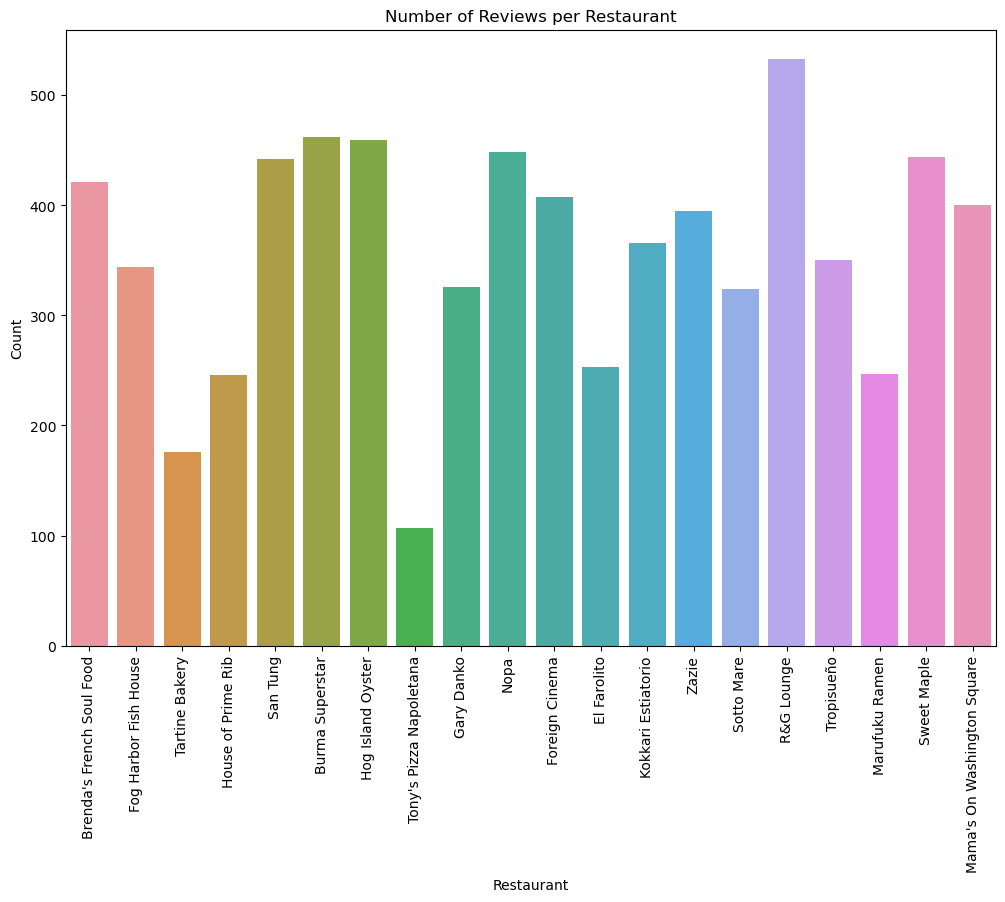

In [322]:
# Example: Countplot of Restaurants
plt.figure(figsize=(12, 8))
sns.countplot(data=sampled_data, x='Restaurant')
plt.title('Number of Reviews per Restaurant')
plt.xticks(rotation=90)
plt.xlabel('Restaurant')
plt.ylabel('Count')
plt.show()


### Plot between no of reviews per food item

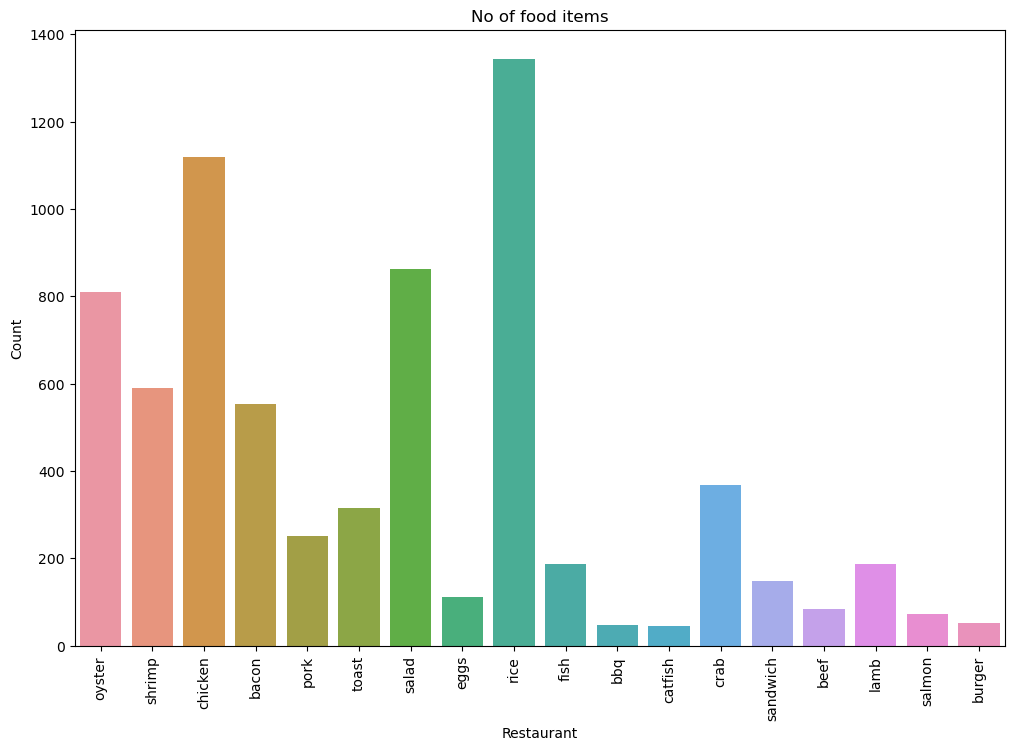

In [323]:
plt.figure(figsize=(12, 8))
sns.countplot(data=sampled_data, x='Item')
plt.title('No of food items')
plt.xticks(rotation=90)
plt.xlabel('Restaurant')
plt.ylabel('Count')
plt.show()


### Average review per item

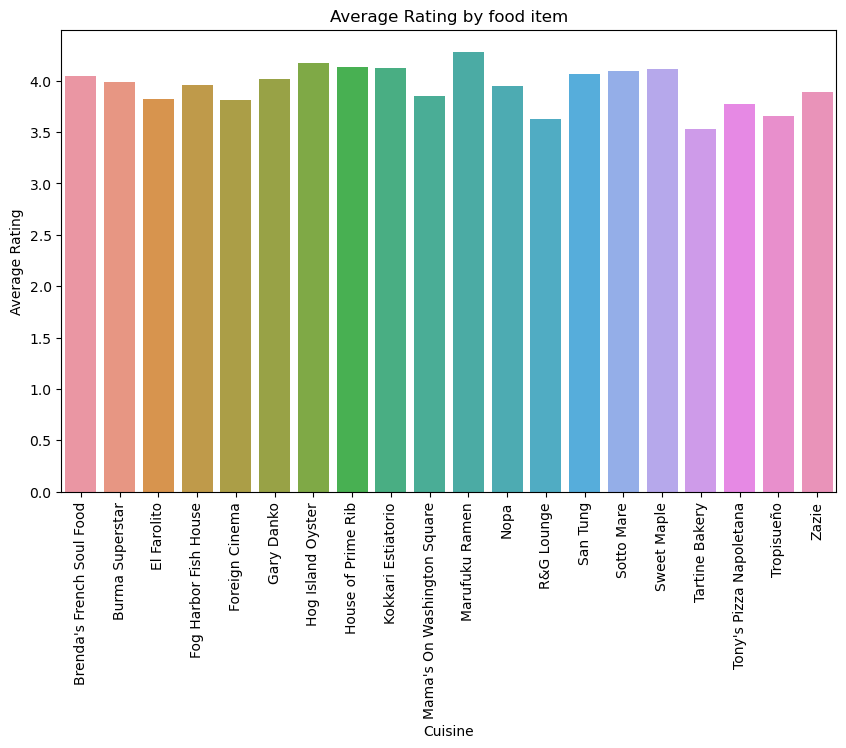

In [324]:
average_ratings_by_item = sampled_data.groupby('Restaurant')['Rating'].mean().reset_index()

# Find the cuisine with the highest average rating
highest_rated_cuisine = average_ratings_by_item.loc[average_ratings_by_item['Rating'].idxmax()]

# Create a bar plot to visualize average ratings by cuisine
plt.figure(figsize=(10, 6))
sns.barplot(data=average_ratings_by_item, x='Restaurant', y='Rating')
plt.title('Average Rating by food item')
plt.xlabel('Cuisine')
plt.ylabel('Average Rating')
plt.xticks(rotation=90)
plt.show()

### A violin plot to visualize the distribution of ratings by food items

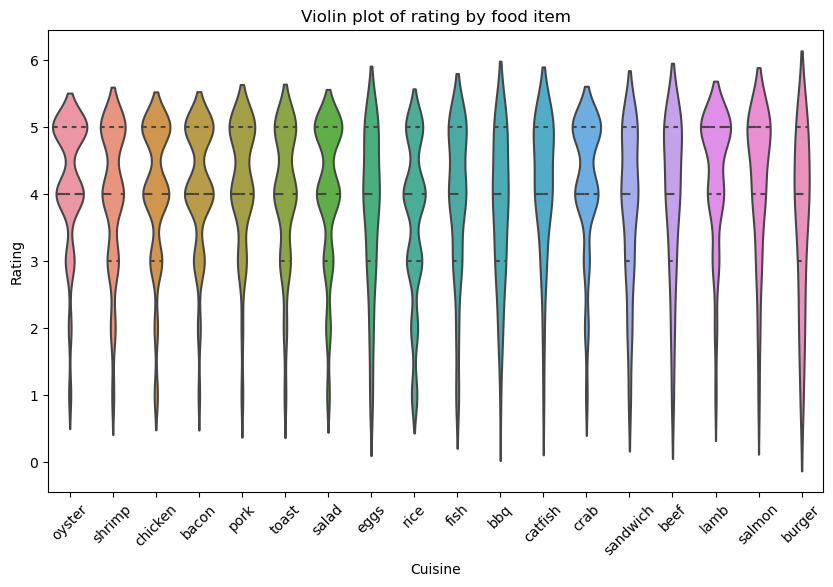

In [325]:

# Create a violin plot to visualize the distribution of ratings by cuisine
plt.figure(figsize=(10, 6))
sns.violinplot(data=sampled_data, x='Item', y='Rating', inner='quart')
plt.title('Violin plot of rating by food item')
plt.xlabel('Cuisine')
plt.ylabel('Rating')
plt.xticks(rotation=45)
plt.show()

### Rating trend of items over a time
In this section , only four popular items and most  are taken into consideration

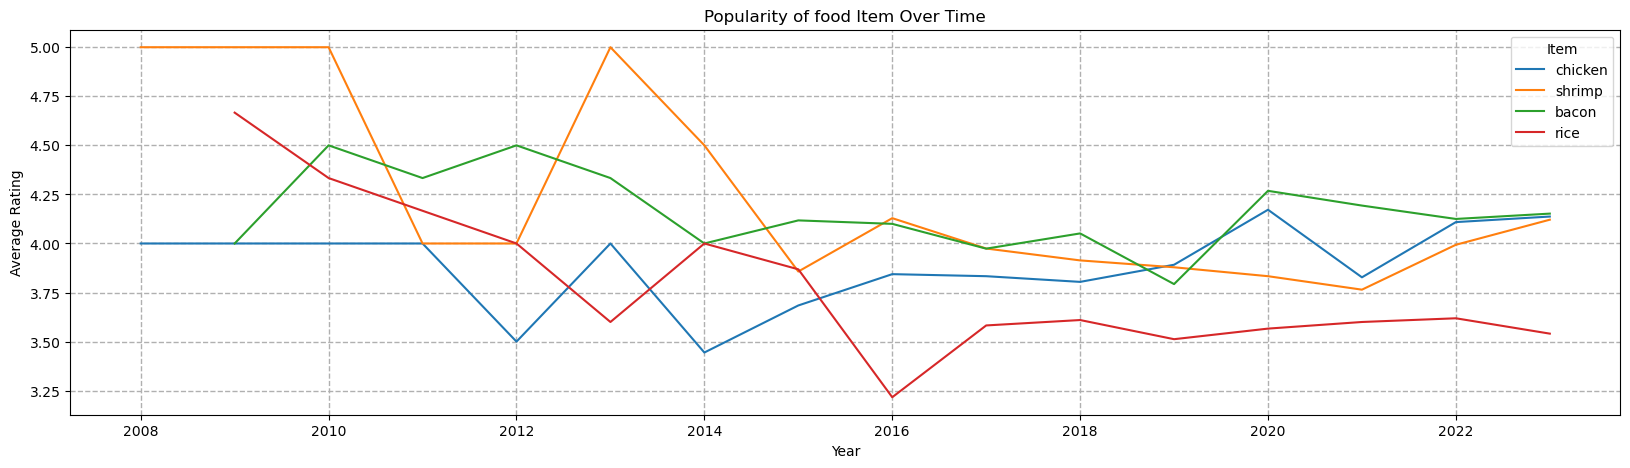

In [326]:
items_to_compare = ['rice', 'chicken' , 'bacon' , 'shrimp']

# Filter data for the selected cuisines
item_data = sampled_data[sampled_data['Item'].isin(items_to_compare)]

item_data['Year'] = item_data['Date'].dt.year
yearly_mean_ratings = item_data.groupby(['Year', 'Item'])['Rating'].mean().reset_index()

# Create a line plot to visualize the popularity of selected cuisines over time
plt.figure(figsize=(20, 5))
sns.lineplot(data=yearly_mean_ratings, x='Year', y='Rating', hue='Item')
plt.title('Popularity of food Item Over Time')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.legend(title='Item')
plt.grid(True ,which='both',linestyle='--', linewidth=1)
plt.show()


# Data preprocessing for ML algorithm

In [327]:
final_data = sampled_data[['Lemmatized_Review' ,'Rating']]

### Encoding rating values to positive, neutral and negative

In [328]:
#mapping numerical values
rating_to_sentiment = {
    1: 'negative',
    2: 'negative',
    3: 'neutral',
    4: 'positive',
    5: 'positive'
}


In [329]:
final_data.loc[: ,'Sentiment'] = final_data['Rating'].map(rating_to_sentiment)

In [330]:
final_data.head(5)

,Lemmatized_Review,Rating,Sentiment
0,"[recent, visit, brendas, soul, food, up, down,...",3,neutral
1,"[really, want, like, place, find, pbs, show, c...",3,neutral
2,"[service, impeccable, ever, food, not, amaze, ...",3,neutral
3,"[not, experience, food, hop, fry, chicken, lac...",3,neutral
4,"[unacceptable, first, stop, right, plane, exci...",1,negative


### Encoding reviews 
1 is given to positive review, 0 is given to neutral review, -1 is given to negative review

In [331]:
final_data.loc[: ,'Sentiment_encoded'] = final_data['Sentiment'].apply(lambda x: -1 if x == 'negative' else (1 if x == 'positive' else 0))

In [332]:
final_data.head(5)

,Lemmatized_Review,Rating,Sentiment,Sentiment_encoded
0,"[recent, visit, brendas, soul, food, up, down,...",3,neutral,0
1,"[really, want, like, place, find, pbs, show, c...",3,neutral,0
2,"[service, impeccable, ever, food, not, amaze, ...",3,neutral,0
3,"[not, experience, food, hop, fry, chicken, lac...",3,neutral,0
4,"[unacceptable, first, stop, right, plane, exci...",1,negative,-1


### Filter Dataframe
Keep only necessary values

In [333]:
ready_data= final_data[['Lemmatized_Review','Sentiment_encoded']]

In [334]:
ready_data['Lemmatized_Review'] = ready_data['Lemmatized_Review'].apply(' '.join)



### TF-IDF vectorization
TF-IDF (Term Frequency-Inverse Document Frequency) is a popular technique in natural language processing for converting text data into numerical representations. It quantifies the importance of words within a document relative to a larger collection of documents, known as a corpus. TF-IDF takes into account both the frequency of a term within a document (Term Frequency) and its uniqueness or rarity across the entire corpus (Inverse Document Frequency).

In [335]:
X =ready_data['Lemmatized_Review']  
y = ready_data['Sentiment_encoded']  

# Split  data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the TF-IDF vectorizer on the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the testing data using the same vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Machine Learning Algorithms

In [336]:
#Dictionary to add scores
scores_dict = {}

# Function to add scores for a new experiment
def add_scores(algorithm, f1_score, accuracy):
    scores_dict[algorithm] = {'F1': f1_score, 'Accuracy': accuracy}


## SVM Classifier

In [337]:
# Initialize the SVM classifier
svm_classifier = SVC(C=5 ,kernel='rbf' , class_weight='balanced')

# Train the SVM classifier 
svm_classifier.fit(X_train_tfidf, y_train)

# Make predictions 
predictions_svm = svm_classifier.predict(X_test_tfidf)

# Evaluate the model using accuracy
accuracy_svm = accuracy_score(y_test, predictions_svm)
f1_svm = f1_score(y_test, predictions_svm, average='weighted') 
print("Accuracy:", accuracy_svm)
print("F1 Score:",f1_svm)
add_scores('svm_classifier', f1_svm, accuracy_svm)
confusion_svm = confusion_matrix(y_test, predictions_svm)
print("Confusion Matrix:\n",confusion)

Accuracy: 0.8148148148148148
F1 Score: 0.7912303682491149
Confusion Matrix:
 [[  76   36   53]
 [  20   87  135]
 [   4   17 1003]]


##  NB Classifier

In [338]:
# Initialize the NB classifier
nb_classifier = MultinomialNB(alpha = 0.2 , fit_prior = False , class_prior = [0.9, 0.7, 0.3])

# Train the NB classifier 
nb_classifier.fit(X_train_tfidf, y_train)

# Make predictions
predictions_nb = nb_classifier.predict(X_test_tfidf)

# Evaluate the model using accuracy and F1 score
accuracy_nb = accuracy_score(y_test, predictions_nb)
f1_nb = f1_score(y_test, predictions_nb, average='weighted')  # You can choose 'weighted', 'micro', 'macro', or 'binary' as the 'average' parameter

# Print the accuracy and F1 score
print("Accuracy:", accuracy_nb)
print("F1 Score:", f1_nb)
add_scores('nb_classifier', f1_nb, accuracy_nb)
confusion_nb = confusion_matrix(y_test, predictions_nb)
print("Confusion Matrix:\n",confusion_nb)

Accuracy: 0.7638015373864431
F1 Score: 0.7701058557971993
Confusion Matrix:
 [[ 82  70  13]
 [ 15 127 100]
 [ 18 122 884]]


## Logistic Regression 

In [339]:
# Initialize Logistic Regression classifier
logistic_classifier = LogisticRegression(C = 1 , solver = 'liblinear')

# Train the Logistic Regression classifier 
logistic_classifier.fit(X_train_tfidf, y_train)

# Make predictions 
predictions_lr = logistic_classifier.predict(X_test_tfidf)

# Evaluate the model using accuracy and F1 score
accuracy_lr = accuracy_score(y_test, predictions_lr)
f1_lr = f1_score(y_test, predictions_lr, average='weighted')

# Print the accuracy and F1 score
print("Accuracy:", accuracy_lr)
print("F1 Score:", f1_lr)
add_scores('logistic_classifier', f1_lr, accuracy_lr)
confusion_lr = confusion_matrix(y_test, predictions_lr)
print("Confusion Matrix:\n",confusion_lr)

Accuracy: 0.7945492662473794
F1 Score: 0.7552316977028807
Confusion Matrix:
 [[  57   26   82]
 [  10   64  168]
 [   1    7 1016]]


## Decision Tree Classifier

In [340]:
# Initialize Decision Tree classifier
decision_tree_classifier = DecisionTreeClassifier(max_depth=10 , min_samples_leaf=3 , splitter='best')

# Train the Decision Tree classifier 
decision_tree_classifier.fit(X_train_tfidf, y_train)

# Make predictions 
predictions_tree = decision_tree_classifier.predict(X_test_tfidf)

# Evaluate the model using accuracy and F1 score
accuracy_tree = accuracy_score(y_test, predictions_tree)
print("Accuracy:", accuracy_tree)
f1_tree = f1_score(y_test, predictions_tree ,average= 'weighted')
print("F1 Score:", f1_tree)
add_scores('decision_tree', f1_tree, accuracy_tree)
confusion_tree = confusion_matrix(y_test, predictions_tree)
print("Confusion Matrix:\n",confusion_tree)



Accuracy: 0.7085953878406709
F1 Score: 0.679887755932088
Confusion Matrix:
 [[ 42  32  91]
 [ 37  50 155]
 [ 41  61 922]]


### Plot accuracy and f1 scores for each ML algorithm
The accuracy and f1 scores for each ML algorithm is plotted

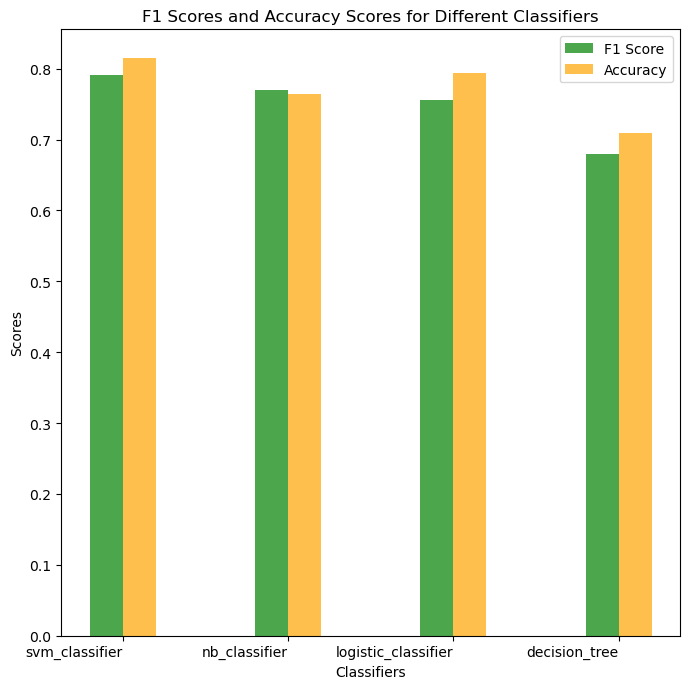

In [341]:
experiments = list(scores_dict.keys())
f1_scores = [scores_dict[experiment]['F1'] for experiment in experiments]
accuracy_scores = [scores_dict[experiment]['Accuracy'] for experiment in experiments]

# Set the width of the bars and their positions
bar_width = 0.20
index = np.arange(len(experiments))

# Create a bar plot 
plt.figure(figsize=(7, 7))
plt.bar(index, f1_scores, bar_width, label='F1 Score', color='green', alpha=0.7)
plt.bar(index + bar_width, accuracy_scores, bar_width, label='Accuracy', color='orange', alpha=0.7)
plt.xlabel('Classifiers')
plt.ylabel('Scores')
plt.title('F1 Scores and Accuracy Scores for Different Classifiers')
plt.xticks(index + bar_width / 2, experiments, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# LDA
LDA analysis for the most frequently used 30  topics 

In [342]:
#data for LDA
rev = X_train.to_list()

In [343]:
# tokenize training data
words_for_lda = []
for word in rev:
    words_for_lda.append(words)


## Training LDA model

In [344]:
dictionary = corpora.Dictionary(words_for_lda)
corpus = [dictionary.doc2bow(tokens) for tokens in words_for_lda]

# Train the LDA model
lda_model = LdaModel(corpus, num_topics=50, id2word=dictionary)

# Print the topics
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(10, '0.040*"best" + 0.028*"better" + 0.028*"brendas" + 0.027*"one" + 0.026*"bring"')
(5, '0.023*"better" + 0.023*"beignets" + 0.022*"time" + 0.021*"gumbo" + 0.021*"bring"')
(40, '0.034*"best" + 0.030*"one" + 0.027*"not" + 0.026*"beignets" + 0.026*"chicken"')
(13, '0.040*"best" + 0.027*"one" + 0.027*"bring" + 0.027*"gumbo" + 0.027*"better"')
(48, '0.040*"best" + 0.030*"brendas" + 0.027*"gumbo" + 0.026*"time" + 0.026*"better"')
(14, '0.038*"best" + 0.026*"delicious" + 0.026*"gumbo" + 0.026*"one" + 0.025*"chicken"')
(27, '0.040*"best" + 0.027*"one" + 0.026*"time" + 0.026*"better" + 0.026*"bring"')
(44, '0.040*"best" + 0.030*"not" + 0.028*"beignets" + 0.027*"chicken" + 0.027*"better"')
(32, '0.034*"best" + 0.028*"get" + 0.026*"time" + 0.026*"bring" + 0.026*"better"')
(39, '0.028*"best" + 0.026*"delicious" + 0.026*"better" + 0.026*"gumbo" + 0.025*"chicken"')
(49, '0.035*"best" + 0.027*"fry" + 0.026*"one" + 0.025*"time" + 0.025*"not"')
(34, '0.026*"best" + 0.026*"time" + 0.022*"beignets" + 

## LDA visualization

In [345]:
# prepared data object for visualization
lda_display = gensimvis.prepare(lda_model, corpus, dictionary)

pyLDAvis.display(lda_display)
